Работать будем с популярным датасетом Medical Cost Personal [Datasets](https://www.kaggle.com/mirichoi0218/insurance).

[файл с данными](https://lms-cdn.skillfactory.ru/assets/courseware/v1/12aeb6a8af2d5cdf500e55d3ccbb9f8e/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/insurance.zip)

Необходимые нам библиотеки:

In [50]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

Читем данные:

In [51]:
data = pd.read_csv('data/insurance.zip')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

- `age` — возраст страхователя;
- `sex` — пол;
- `bmi` — индекс массы тела ($кг/м^2$), в идеале — от 18.5 до 24.9;
- `children` — количество детей, охваченных медицинской страховкой;
- `smoker` — является ли человек курящим;
- `region` — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
- `charges` (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

Размер таблицы:

In [52]:
print(data.shape)

(1338, 7)


Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

In [53]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

Посмотрим на типы данных:

In [54]:
job_data = data.copy()
display(job_data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

- `age`, `bmi`, `children` — числовые признаки;
- `sex`, `smoker` — бинарные категориальные переменные (две категории);
- `region` — множественные категориальные переменные (несколько категорий);
- `charges` — числовой целевой признак.

Прежде чем приступать к этапу подготовки данных для модели, проведем небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

- гистограммы/коробчатые диаграммы числовых признаков;
- столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
- диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).

In [55]:
#выделим имена числовых признаков в виде списка для удобства дальнейшей работы
types = job_data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

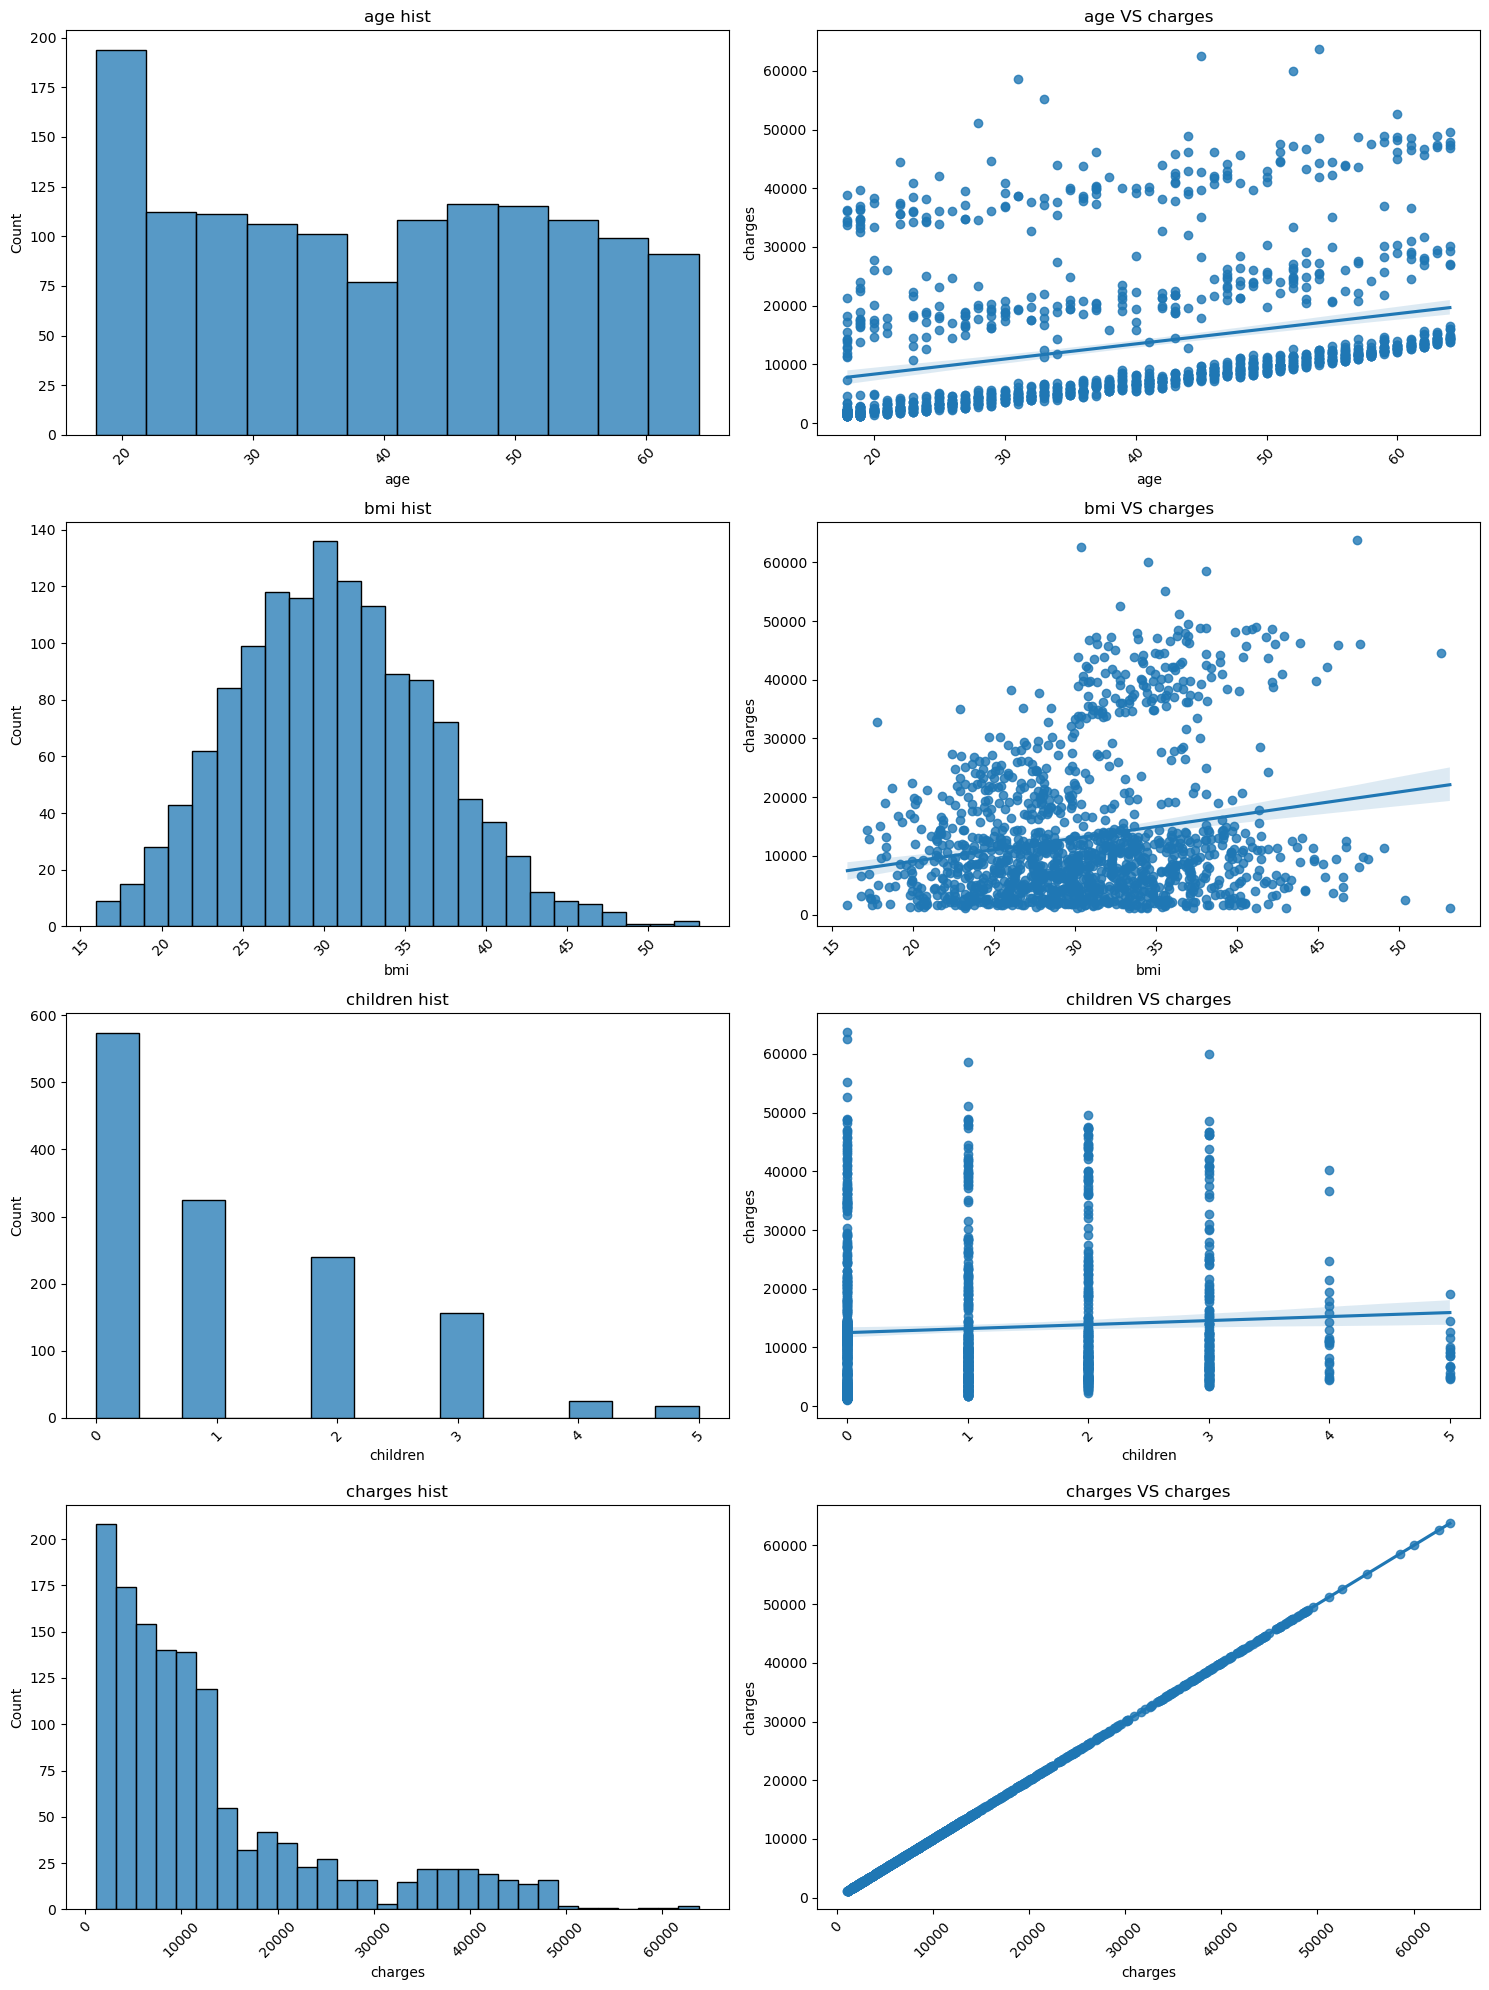

In [ ]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака
    histplot = sns.histplot(data=job_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=job_data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

- `smoker` — переведём в бинарные значения (0 — некурящий, 1 — курящий);
- `sex` — аналогично (0 — female, 1 — male);
- `region` — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [57]:
#кодируем бинарные категориальные признаки
job_data['smoker'] = job_data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
job_data['sex'] = job_data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
job_data = pd.get_dummies(job_data)
job_data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


Итак, мы получили перекодированную таблицу, в которой все признаки являются числовыми.

Выделим `факторы` и `целевой признак` в отдельные таблицы:

In [58]:
features = job_data.drop('charges', axis=1).columns
X, y = job_data[features], job_data['charges']

Теперь мы можем начинать работу над моделью:

`Задание 6.1`

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на `тренировочную` и `тестовую` выборки в соотношении `80/20`. Воспользуйтесь функцией `train_test_split`.

В качестве значения параметра `random_state` укажите число `42`.

Чему равно количество наблюдений в тестовом наборе данных?

In [59]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


`Задание 6.2`

Обучите модель линейной регрессии аналитическим методом (`LinearRegression`) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

Чему равен свободный член (`intercept`) обученной модели? Ответ округлите до сотых.

In [63]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)

print(round(lr.intercept_,2))

-12390.8


`Задание 6.3`

С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики:$R^2$, $MAE$, $MAPE$. Не забудьте привести значение MAPE$ к процентам.

Значение $R^2$ округлите до трёх знаков после точки-разделителя, а значения $MAE$ и $MAPE$ — до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [67]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [68]:
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42


Test R^2: 0.784
Test MAE: 4181
Train MAPE: 47


`Задание 6.4`

Постройте диаграмму `boxplot` для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: $y - \hat{y}$ (без модуля).

Выберите верные ответы:

- A Разброс ошибок на тестовой выборке больше, чем на тренировочной.
- `B Разброс ошибок на тренировочной выборке больше, чем на тестовой`.
- `C Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0)`.
- D Медианная ошибка на тренировочной и тестовой выборках положительная (больше 0)

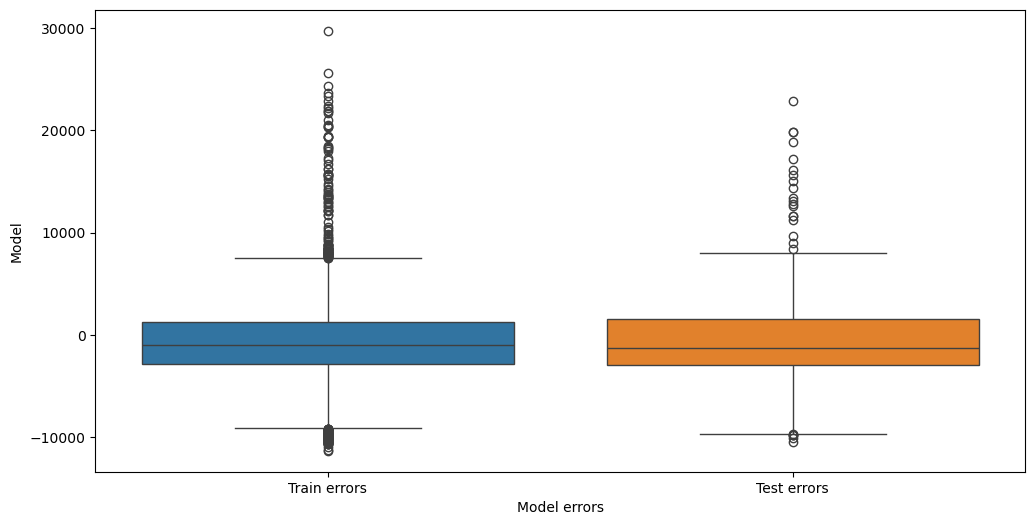

In [ ]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors,
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

`Задание 6.5`

Нормализуйте `тренировочную` и `тестовую` выборки с помощью `min-max-нормализации` (`MinMaxScaler`). Расчёт параметров нормализации (`fit`) произведите на тренировочной выборке.

> Примечание. `Min-max-нормализация` не искажает изначальный вид бинарных категориальных признаков, в отличие от `стандартизации`.

`На нормализованных` данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом `PolynomialFeatures` из библиотеки `sklearn`. Значение параметра `include_bias` выставите на `False`.

In [70]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок (нормализуем данные)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))


Train shape: (1070, 54)
Test shape: (268, 54)


`Задание 6.6`

Обучите модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики $R^2$ на тестовой выборке?

Значение  округлите до трёх знаков после запятой.

In [73]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2892
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2730
Train MAPE: 30


`Задание 6.7`

Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

Какой вывод можно сделать?

- `Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.`
- Значения коэффициентов приемлемые, модель устойчива, регуляризация не нужна.

In [78]:
print(lr_poly.coef_)

[ 2849.35067435  -417.24034999  5935.92169643  4636.08544526
  1139.1491985    351.86496094  -366.48563336   227.08922666
  -212.46855424  8399.63608632   812.46558472   995.68651894
 -1666.91118191   172.50303109  -848.02252419   280.84325571
  1455.92298005  1960.60696278  -417.24034999   647.47475622
 -1238.19812114   257.33745404  -966.67881613   311.8232212
   544.21466602  -306.59942109 -9711.00034091  1559.87212018
 54839.212545    3782.01457236  2765.86075737  -794.72610916
   182.77247586 -2090.61756751 -2233.48411893  2438.06291171
  2463.6574199    410.25306251  -675.88794885  1139.1491985
   318.56157022  -298.80831333  -589.98196067  1709.37790228
   351.86496094     0.             0.             0.
  -366.48563336     0.             0.           227.08922666
     0.          -212.46855424]


`Задание 6.8`

Постройте линейную регрессию с `L1-регуляризацией` (Lasso) на полиномиальных признаках. В качестве параметра `alpha` используйте значение по умолчанию, параметр `max_iter` установите в значение `2000`.

Чему равны метрики $R^2$, $MAE$ и $MAPE$ на `тестовой` выборке?

Значение $R^2$ округлите до трёх знаков после запятой, а значения $MAE$ и $MAPE$ до целого числа.

In [ ]:
#Инициализируем объект класса линейная регрессия с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель предсказывать целевоq признак
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_pred = lasso_lr_poly.predict(X_test_scaled_poly)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2890
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2719
Train MAPE: 30


`Задание 6.9`

Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.

Чему равны метрики $R^2$, $MAE$ и $MAPE$ на `тестовой` выборке?

Значение $R^2$ округлите до трёх знаков после запятой, а значения $MAE$ и $MAPE$ до целого числа.

In [ ]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель предсказывать целевоq признак
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30


Test R^2: 0.863
Test MAE: 2861
Train MAPE: 31


#### Поздравляем! Вы познакомились со своими первыми моделями машинного обучения!

Напоследок ещё раз обсудим, что мы сделали в модуле:

- узнали, что такое модель линейной регрессии;
- изучили несколько методов поиска параметров этой модели, реализованных в sklearn: метод наименьших квадратов (LinearRegression) и стохастический градиентный спуск (SGDRegressor);
- выявили достоинства и недостатки каждого из методов;
- научились делать предсказание с помощью модели линейной регрессии;
- познакомились с метриками регрессии и научились измерять качество регрессионной модели;
- узнали о центральной проблеме обучения с учителем – дилемме смещения и разброса, научились определять переобученность модели;
- научились строить полиномиальную регрессию и бороться с переобучением с помощью регуляризации.

Методы решения задачи регрессии, которые мы рассмотрели в модуле:

- `LinearRegression` и `SGDRegressor` — модели линейной регрессии с аналитическим и численным решением;
- `PolynomialFeatures` + `LinearRegression` — модель полиномиальной регрессии (или линейная регрессия на полиномиальных признаках);
- `Lasso` и `Ridge` — модели линейной регрессии с L1- и L2-регуляризацией соответственно.

Стоит отметить, что, помимо рассмотренных, существует ещё множество методов решения задачи регрессии, с которыми мы будем знакомиться дальше.

Дополнительно:

- [Десять датасетов для практики работы с линейной регрессией](https://www.telusinternational.com/articles/10-open-datasets-for-linear-regression)
- [Базовые принципы машинного обучения на примере линейной регрессии](https://habr.com/ru/company/ods/blog/322076/)
- [Регрессионные модели в Python](https://nagornyy.me/it/regressionnye-modeli-v-python/)